# Actor-Critic evaluation

Plan:
- ~~Spike Actor-Critic~~
- ~~Quick test on a Gym env~~
- ~~Update requirements.txt~~
- ~~Move Actor-Critic out~~
- ~~Make training records for analysis~~
- Structure next code

## Imports & setup

### Essential tools

In [26]:
# Generic setup
import math
import numpy as np
from typing import Tuple, List, Callable
from collections import namedtuple

In [28]:
# Analysis
from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

### Examine Gym environments

In [30]:
# %%capture
# from gym import envs
# print(envs.registry.all())

In [32]:
import gym

In [117]:
# Smoke test
env = gym.make("CartPole-v1")
# env = gym.make("Pong-v0")
# # Check environment details
# CartPole-v0 is 200, 195.0
# CartPole-v1 is 500, 475.0
# Pong-v0 is 10000, None, 6, 255
env.spec.max_episode_steps, env.spec.reward_threshold, env.action_space, env.observation_space

# Rememeber to make reproducible gym environments
# env.seed(0)

(500,
 475.0,
 Discrete(2),
 Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32))

### Import PyTorch

In [188]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducible results
torch.manual_seed(0)

In [38]:
%%capture
!pip install stable_baselines3==1.0

In [40]:
# Import only for multiprocessing
import stable_baselines3
from stable_baselines3.common.env_util import SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed

### Import local modules

In [42]:
from actor_critic import ActorCritic

## Set up evaluation

Gym CartPole V0 & V1 description:

>A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

Four terminating states for CartPole-v1:
- env.spec.max_episode_steps 500
- env.spec.reward_threshold 475.0
- pole is more than 15 degrees from vertical
- the cart moves more than 2.4 units from the centre

https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f

Doing A2C, a single worker variant of A3C.
- backprop
- keep the hidden layer simple (1)
- ADAM as loss function (RMSprop was very stable as recommended in stable-baselines3, but reward was very poor)
- reward step size/evaluation step size 5

Hyperparameters:
(values from Deep Reinforcement Learning Hands-On, Maxim Lapan)
- num of envs used [20, 40, 60, 80, 100]
- ~~batch size [16, 32, 64]~~
- num_episodes [50000, 100000]
- learning rate [0.001, 0.002, 0.003]
- entropy beta? [0.02, 0.03]
- value coefficient [0.1, 0.3, 0.5]
- hidden layers? [(32, 32), (64, 64), (128, 128)]
- reward step bootstrapping [5, 10] (Though 10 was very careless earlier)

Performance analysis:
- Reward
- policy loss
- value loss
- overall loss
- ~~No. of timesteps per episode (before terminating state)~~ No need as timesteps == rewards
- No need for wallclock time as we don't want to compare this for now.


In [266]:
def plot_rewards_episodes(episode_idx: int, experiment_rewards: list):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title(f"Last reward of {experiment_rewards[-1]} after {episode_idx} episodes")
    plt.xlabel("Per 1000 episodes")
    plt.ylabel("Reward")
    plt.plot(experiment_rewards)
    plt.show()


In [214]:
# One episode/test run/logging rewards
def sample_one_episode(env: gym.Env, model: ActorCritic):
    state = env.reset()
    done = False

    total_reward = 0

    while not done:
        state = torch.unsqueeze(torch.FloatTensor(state), 0).to(device)
        probability_dist, values = model(state)
        action_to_take = probability_dist.sample()
        next_state, reward, done, _ = env.step(action_to_take.cpu().detach().numpy()[0])
        state = next_state

        total_reward += reward

    return total_reward

In [215]:
def calculate_returns(next_value: torch.Tensor, rewards: List[torch.FloatTensor], masks: List[int], gamma: float) -> List[torch.Tensor]:
    calculated_returns = []
    # Calculate the accumulated returns 
    # from the number of "reward steps to update".
    # Reset R to the next_value first.
    R = next_value

    # Calculate discounted return & go backwards
    for _ in range(len(rewards))[::-1]:
        R = rewards[_] + gamma * R * masks[_]
        # Push return value R
        calculated_returns.insert(0, R)
    return calculated_returns


In [250]:
# From: https://colab.research.google.com/github/Stable-Baselines-Team/rl-colab-notebooks/blob/sb3/multiprocessing_rl.ipynb

def make_env(env_id: str, rank: int, seed: int = 0) -> Callable:
    """
    Utility function for multiprocessed env.
    
    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environment you wish to have in subprocesses
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    :return: (Callable)
    """
    def _init() -> gym.Env:
        env = gym.make(env_id)
        env.seed(seed + rank)
        return env
    set_random_seed(seed)
    return _init


# Parameters based on environment:
NUM_OBSERVATIONS: int = env.observation_space.shape[0] # input
NUM_ACTIONS: int = env.action_space.n # output

# Hyperparameters
LEARNING_RATE_LIST: list = [0.001, 0.002, 0.003]

# Eduard = MSI RX 2080, 6 cores Intel Core i5 9600KF
# Fei = 6 cores AMD Ryzen 5 3600, I'm not going to install ROCm
NUM_CPU: int = 12  # Number of processes to use

HIDDEN_LAYER_LIST = [(32, 32), (64, 64), (128, 128)]

# Create the vectorized environment
envs = SubprocVecEnv([make_env("CartPole-v1", i) for i in range(NUM_CPU)])

model = ActorCritic(num_inputs=NUM_OBSERVATIONS, num_outputs=NUM_ACTIONS, hidden_layer_config=(128, 128)).to(device)
optimiser = optim.Adam(model.parameters(), lr=0.002)


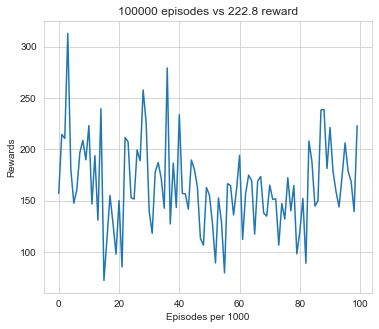

In [261]:
ENTROPY_REGULARISATION: float = 0.001 # Entropy regularisation weight/beta/coefficient
VALUE_LOSS_COEFFICIENT: float = 1.0 # Have seen this as 0.5 and 0.1, we will choose the lower
NUM_EPISODES: int = 100000
NUM_REWARD_STEPS: int = 5
GAMMA = 0.9
MAX_GRADIENT = 1
episode_idx: int = 0
experiment_rewards: list = []
experiment_actor_loss: list = []
experiment_critic_loss: list = []
experiment_overall_loss: list = []
experiment_rewards_var: list = []

state = envs.reset()

while episode_idx < NUM_EPISODES:

    # Structures to hold our records for updating
    log_probs: list = []
    values: list = []
    rewards: list = []

    entropy: int = 0 # reset Entropy
    # Our thresholding tensors which "turn off" returns
    # for the next_value (changes them to zero),
    # if the episode terminates before the 500 max 
    # timesteps on Cartpole-v1 are reached.
    masks: list = []

    for _ in range(NUM_REWARD_STEPS):
        state = torch.FloatTensor(state).to(device)
        probability_distribution, state_values = model(state)
        action_to_take = probability_distribution.sample()

        next_state, reward, done, _ = envs.step(action_to_take.cpu().numpy())
        state = next_state

        # Update all the things:
        values.append(state_values)

        log_prob = probability_distribution.log_prob(action_to_take)
        log_probs.append(log_prob)

        rewards.append(torch.unsqueeze(torch.FloatTensor(reward),1).to(device))

        entropy += probability_distribution.entropy().mean()

        # 1 - False = 1; 1 - True = 0
        # 1 - returns for next value continue to be calculated.
        masks.append(torch.unsqueeze(torch.FloatTensor(1 - done),1).to(device))

        # Increment episode counter
        episode_idx += 1

        if episode_idx % 1000 == 0:
            experiment_rewards.append(np.mean([sample_one_episode(env, model) for _ in range(10)]))
            experiment_rewards_var.append(np.std([sample_one_episode(env, model) for _ in range(10)]))
            plot_rewards_episodes(episode_idx, experiment_rewards)
        
    next_state = torch.FloatTensor(next_state).to(device)
    _, next_state_value = model(next_state)
    returns = calculate_returns(next_state_value, rewards, masks, GAMMA)
 
    # Run the next code with no gradients kept, so that 
    # this can be a bit more efficient.
    # with torch.no_grad():
    # Update everything
    log_probs= torch.cat(log_probs)
    returns = torch.cat(returns).detach()
    values = torch.cat(values)

    advantage = returns - values

    # Or policy loss
    actor_loss = -(log_probs * advantage.detach()).mean()
    experiment_actor_loss.append(actor_loss)

    # Or value loss - using MSE
    critic_loss = advantage.pow(2).mean()
    experiment_critic_loss.append(critic_loss)

    overall_loss = actor_loss + (VALUE_LOSS_COEFFICIENT * critic_loss) - (ENTROPY_REGULARISATION * entropy)
    experiment_overall_loss.append(overall_loss)

    # Clear gradients in optimiser to zero
    # so that we don't accumulate on
    # past gradients.
    optimiser.zero_grad()

    # Propagate loss/weights backwards
    overall_loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRADIENT)
    # Update model parameters
    optimiser.step()

    # TODO: Gradient clipping?
    # nn.utils.clip_grad_norm_(model.parameters(), MAX_GRADIENT)


In [252]:

min(experiment_rewards), max(experiment_rewards), np.std(experiment_rewards), np.mean(experiment_rewards)
# VALUE_LOSS_COEFFICIENT = 0.1
# 85.6 218.6, 32.21718150304275

# VALUE_LOSS_COEFFICIENT = 0.5
# (81.8, 242.8, 35.98530639024768, 162.418)

# NUM_EPISODES = 100000
# (101.4, 310.5, 34.232210723235504, 168.143)

# VALUE_LOSS_COEFFICIENT = 0.01
# (84.4, 291.4, 41.10671160528412, 161.66899999999998)

# NUM_REWARD_STEPS: int = 10
# (37.9, 168.4, 22.67719777662134, 81.899)

# lr=0.0001
# (74.7, 224.5, 29.891392389783388, 145.119)

# I changed nothing
# (80.9, 214.8, 29.989488341750683, 133.78300000000002)

# Adam lr: 0.002, gradient clipping: 1 
# The policy is weighted at 1.0, value function at 0.6, entropy at 0.001.
# We go for 10-step bootstrapping, eight workers, and a 0.95 tau.
# (18.0, 468.1, 94.37116402800169, 223.33999999999997)

# 12 workers, 32x32
# (20.2, 428.8, 93.23209095585061, 224.504)
# 12 workers, 128 x 128
# (23.8, 483.7, 110.44132099898115, 258.804)



(23.8, 483.7, 110.44132099898115, 258.804)

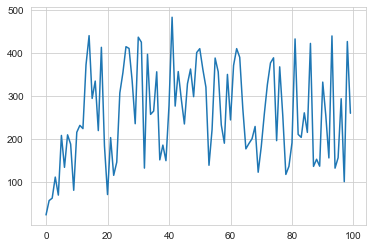

In [253]:
plt.title(f"Last reward of {experiment_rewards[-1]} after {NUM_EPISODES} episodes")
plt.xlabel("Per 1000 episodes")
plt.ylabel("Rewards")
plt.plot(experiment_rewards)

def plot_actor_loss(episode_idx: int, experiment_actor_loss: list):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title(f"{episode_idx} episodes vs {experiment_actor_loss[-1]} actor loss")
    plt.xlabel("Updates")
    plt.ylabel("Actor Loss")
    plt.plot(experiment_actor_loss)
    plt.show()

def plot_critic_loss(episode_idx: int, experiment_critic_loss: list):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title(f"{episode_idx} episodes vs {experiment_critic_loss[-1]} critic loss")
    plt.xlabel("Updates")
    plt.ylabel("Critic Loss")
    plt.plot(experiment_critic_loss)
    plt.show()

def plot_overall_loss(episode_idx: int, experiment_overall_loss: list):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title(f"{episode_idx} episodes vs {experiment_overall_loss[-1]} overall loss")
    plt.xlabel("Updates")
    plt.ylabel("Overall Loss")
    plt.plot(experiment_overall_loss)
    plt.show()

def plot_rewards_var(episode_idx: int, experiment_rewards_var: list):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title(f"{episode_idx} episodes vs {experiment_rewards_var[-1]} rewards var")
    plt.xlabel("Episodes per 1000")
    plt.ylabel("Rewards Var")
    plt.plot(experiment_rewards_var)
    plt.show()

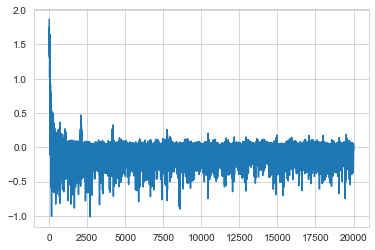

In [254]:
# experiment_actor_loss[0].item()

experiment_actor_loss_list = [loss.item() for loss in experiment_actor_loss]

sns.lineplot(data=experiment_actor_loss_list);

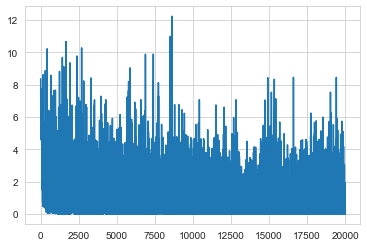

In [255]:
experiment_critic_loss_list = [loss.item() for loss in experiment_critic_loss]

sns.lineplot(data=experiment_critic_loss_list);

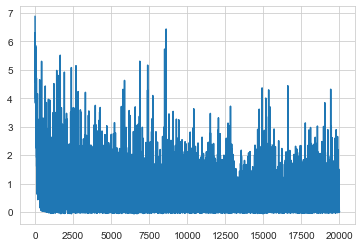

In [256]:
experiment_overall_loss_list = [loss.item() for loss in experiment_overall_loss]

sns.lineplot(data=experiment_overall_loss_list);

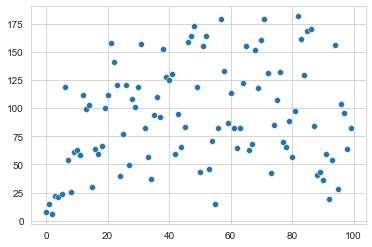

In [204]:
sns.scatterplot(data=experiment_rewards_var);

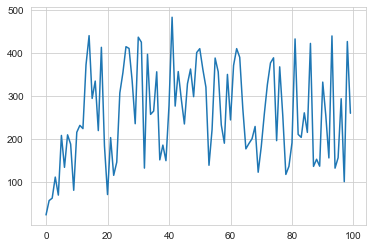

In [257]:
plt.plot(experiment_rewards)
plt.savefig("good-model3.png", dpi=300, bbox_inches="tight")
plt.show()

In [258]:
# TODO: make results folders with timestamp
# TODO: Rename the model files with hyperparameters
# TODO: Save and name the graphs/plots with hyperparameters

# Specify a path
PATH = "results/good_model3.pt"

# Save
torch.save(model, PATH)

# Load
model_load = torch.load(PATH)
model_load.eval()

model_load.state_dict()

model_load_env = gym.make("CartPole-v1")
state = model_load_env.reset()


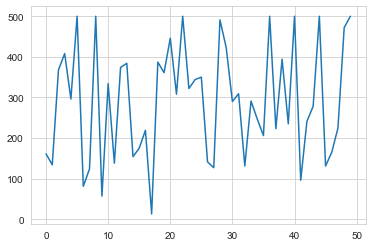

In [264]:
model_load_env = gym.make("CartPole-v1")
model_load_env.seed(0)

model_load_total_rewards = []

for _ in range(50):
    model_load_rewards = sample_one_episode(env=model_load_env,model=model_load)
    model_load_total_rewards.append(model_load_rewards)

model_load_total_rewards

plt.plot(model_load_total_rewards);

In [265]:
min(model_load_total_rewards), max(model_load_total_rewards), np.std(model_load_total_rewards), np.mean(model_load_total_rewards)

(13.0, 500.0, 139.60198279394174, 291.08)